In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

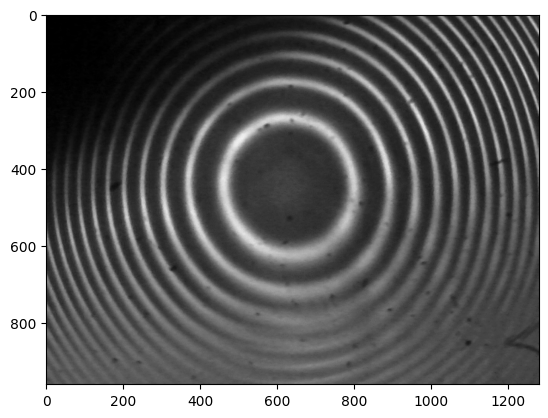

In [66]:
img = cv2.imread("/home/tushara/Documents/Ashoka/Lab 4/Data/exp1/thickness_measurement.png", 0)
plt.imshow(img, cmap = "gray")
plt.show()

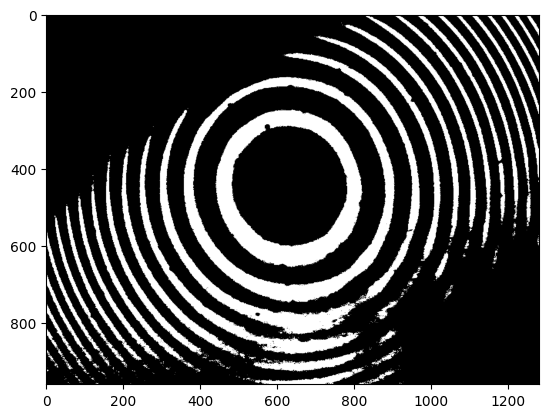

True

In [74]:
ret, imgthres = cv2.threshold(img,50,255, 0)
plt.imshow(imgthres, cmap = "gray")
plt.show()
cv2.imwrite("A4.png", imgthres)

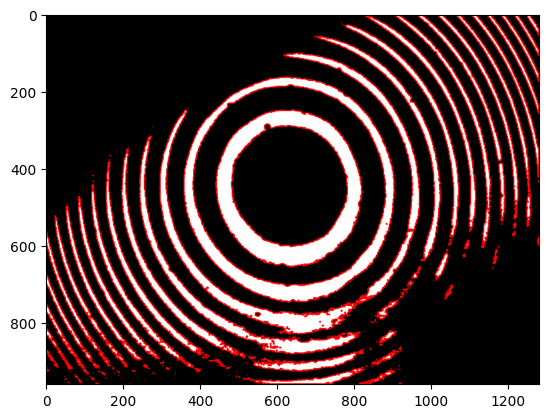

True

In [68]:
contours, hierarchy = cv2.findContours(imgthres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
imgcont = cv2.cvtColor(imgthres, cv2.COLOR_GRAY2BGR)
cv2.drawContours(imgcont, contours, -1, (0,0,255), 2)
imgcont = cv2.cvtColor(imgcont, cv2.COLOR_BGR2RGB)
plt.imshow(imgcont)
plt.show()


632 453


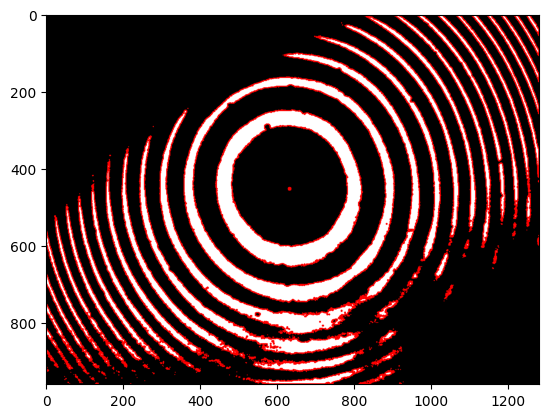

True

In [72]:
c = max(contours, key=cv2.contourArea)
M = cv2.moments(c)
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])

print(cx,cy)
cv2.circle(imgcont, (cx, cy), 5, (255,0,0), -1)
plt.imshow(imgcont, cmap = "gray")
plt.show()


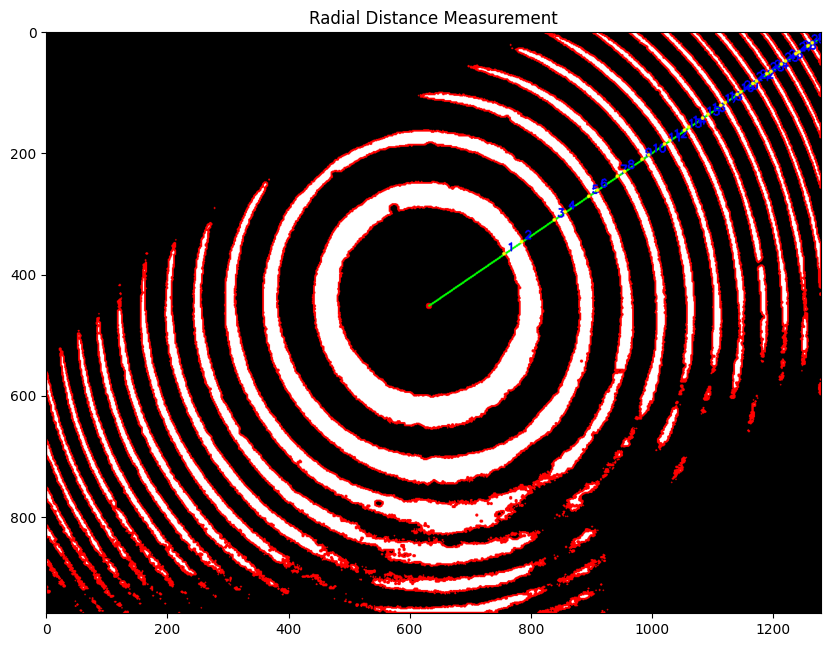

Radii (distances from center along radial line): [150, 186, 251, 273, 320, 337, 377, 391, 427, 440, 471, 482, 512, 520, 548, 558, 584, 592, 617, 624, 648, 655, 676, 684, 705, 714, 735, 740, 758, 767]
Number of rings detected: 30
Ring spacings: [36, 65, 22, 47, 17, 40, 14, 36, 13, 31, 11, 30, 8, 28, 10, 26, 8, 25, 7, 24, 7, 21, 8, 21, 9, 21, 5, 18, 9]


True

In [71]:
# Define the radial line direction (you can change this angle)
# For example, going horizontally to the right (angle = 0)
angle = -0.6 # in radians
line_dx = np.cos(angle)
line_dy = np.sin(angle)

# Find the furthest contour to determine line length
max_distance = 0
for cnt in contours:
    pts = cnt[:, 0, :]
    dists = np.sqrt((pts[:, 0] - cx)**2 + (pts[:, 1] - cy)**2)
    max_distance = max(max_distance, np.max(dists))

# Create points along the radial line from center to beyond the furthest contour
line_length = int(max_distance * 1.2)  # extend 20% beyond furthest point
line_points = []
for t in range(line_length):
    x = cx + t * line_dx
    y = cy + t * line_dy
    line_points.append((int(x), int(y)))

# Create a combined mask of all contours
#combined_mask = imgthres.copy()
combined_mask = np.zeros(imgthres.shape, dtype=np.uint8)
cv2.drawContours(combined_mask, contours, -1, 255, 3)  # Use thickness=1

# Find ALL intersections along the radial line
all_intersections = []
prev_on_contour = False

for i, (x, y) in enumerate(line_points):
    if 0 <= x < combined_mask.shape[1] and 0 <= y < combined_mask.shape[0]:
        on_contour = combined_mask[y, x] > 0
        
        # Only record intersection when we transition FROM off-contour TO on-contour
        if on_contour and not prev_on_contour:
            distance = np.sqrt((x - cx)**2 + (y - cy)**2)
            all_intersections.append((distance, x, y))
        
        prev_on_contour = on_contour

# Sort all intersections by distance from center
all_intersections.sort(key=lambda x: x[0])
radii = [int(r) for r, _, _ in all_intersections]
intersection_points = [(x, y) for _, x, y in all_intersections]

# Visualize the result
imgresult = imgcont.copy()
cv2.circle(imgresult, (cx, cy), 5, (255, 0, 0), -1)  # Center in blue

# Draw the radial line
end_x = cx + int(line_length * line_dx)
end_y = cy + int(line_length * line_dy)
cv2.line(imgresult, (cx, cy), (end_x, end_y), (0, 255, 0), 2)  # Line in green

# Mark intersection points
for i, (int_x, int_y) in enumerate(intersection_points):
    cv2.circle(imgresult, (int_x, int_y), 3, (255, 255, 0), -1)  # Intersections in yellow
    # Optionally add text labels
    cv2.putText(imgresult, f'{i+1}', (int_x+5, int_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

plt.figure(figsize=(10, 8))
plt.imshow(imgresult)
plt.title("Radial Distance Measurement")
plt.show()

print("Radii (distances from center along radial line):", radii)
print("Number of rings detected:", len(radii))
print("Ring spacings:", [radii[i+1] - radii[i] for i in range(len(radii)-1)])